In [74]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [76]:
data = pd.read_csv('data.csv')
data.head()

,Index Name,Date,Open,High,Low,Close
0,NIFTY 50,06 Jun 2025,24748.70,25029.50,24671.45,25003.05
1,NIFTY 50,05 Jun 2025,24691.20,24899.85,24613.10,24750.90
2,NIFTY 50,04 Jun 2025,24560.45,24644.25,24530.45,24620.20
3,NIFTY 50,03 Jun 2025,24786.30,24845.10,24502.15,24542.50
4,NIFTY 50,02 Jun 2025,24669.70,24754.40,24526.15,24716.60


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index Name  1350 non-null   object 
 1   Date        1350 non-null   object 
 2   Open        1350 non-null   float64
 3   High        1350 non-null   float64
 4   Low         1350 non-null   float64
 5   Close       1350 non-null   float64
dtypes: float64(4), object(2)
memory usage: 63.4+ KB


In [78]:
data['Date'] = pd.to_datetime(data['Date'], format='%d %b %Y')
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data.head()


,Index Name,Date,Open,High,Low,Close
0,NIFTY 50,2025-06-06,24748.70,25029.50,24671.45,25003.05
1,NIFTY 50,2025-06-05,24691.20,24899.85,24613.10,24750.90
2,NIFTY 50,2025-06-04,24560.45,24644.25,24530.45,24620.20
3,NIFTY 50,2025-06-03,24786.30,24845.10,24502.15,24542.50
4,NIFTY 50,2025-06-02,24669.70,24754.40,24526.15,24716.60


In [79]:
data.drop(columns=['Index Name'],inplace = True)

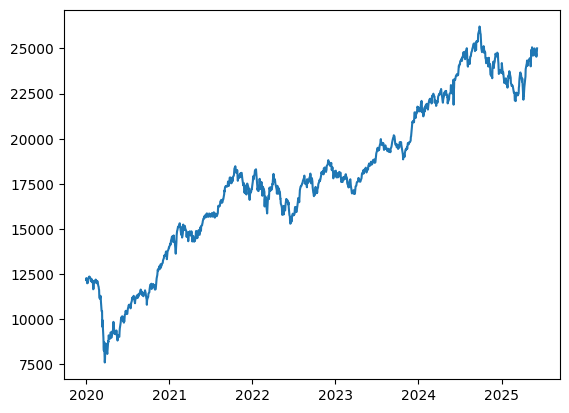

In [80]:
data = data[['Date','Close']]
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [81]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2025-05-28,24752.45,24833.60,24750.70,24716.60,24542.50,24620.20,24750.90,25003.05
2025-05-27,24826.20,24752.45,24833.60,24750.70,24716.60,24542.50,24620.20,24750.90
2025-05-26,25001.15,24826.20,24752.45,24833.60,24750.70,24716.60,24542.50,24620.20
2025-05-23,24853.15,25001.15,24826.20,24752.45,24833.60,24750.70,24716.60,24542.50
2025-05-22,24609.70,24853.15,25001.15,24826.20,24752.45,24833.60,24750.70,24716.60
...,...,...,...,...,...,...,...,...
2020-01-07,12052.95,12025.35,12215.90,12256.80,12329.55,12362.30,12343.30,12355.50
2020-01-06,11993.05,12052.95,12025.35,12215.90,12256.80,12329.55,12362.30,12343.30
2020-01-03,12226.65,11993.05,12052.95,12025.35,12215.90,12256.80,12329.55,12362.30


In [82]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[24752.45, 24833.6 , 24750.7 , ..., 24620.2 , 24750.9 , 25003.05],
       [24826.2 , 24752.45, 24833.6 , ..., 24542.5 , 24620.2 , 24750.9 ],
       [25001.15, 24826.2 , 24752.45, ..., 24716.6 , 24542.5 , 24620.2 ],
       ...,
       [12226.65, 11993.05, 12052.95, ..., 12256.8 , 12329.55, 12362.3 ],
       [12282.2 , 12226.65, 11993.05, ..., 12215.9 , 12256.8 , 12329.55],
       [12182.5 , 12282.2 , 12226.65, ..., 12025.35, 12215.9 , 12256.8 ]])

In [83]:
shifted_df_as_np.shape

(1343, 8)

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.84267271,  0.8513958 ,  0.8424846 , ...,  0.82845672,
         0.8425061 ,  0.86961055],
       [ 0.85060035,  0.84267271,  0.8513958 , ...,  0.82010448,
         0.82845672,  0.8425061 ],
       [ 0.86940631,  0.85060035,  0.84267271, ...,  0.83881908,
         0.82010448,  0.82845672],
       ...,
       [-0.50376764, -0.52887809, -0.52243924, ..., -0.50052672,
        -0.49270658, -0.48918617],
       [-0.49779639, -0.50376764, -0.52887809, ..., -0.5049232 ,
        -0.50052672, -0.49270658],
       [-0.50851347, -0.49779639, -0.50376764, ..., -0.52540606,
        -0.5049232 , -0.50052672]])

In [85]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1343, 7), (1343,))

In [86]:
X = dc(np.flip(X, axis=1))
X

array([[ 0.86961055,  0.8425061 ,  0.82845672, ...,  0.83881908,
         0.8424846 ,  0.8513958 ],
       [ 0.8425061 ,  0.82845672,  0.82010448, ...,  0.8424846 ,
         0.8513958 ,  0.84267271],
       [ 0.82845672,  0.82010448,  0.83881908, ...,  0.8513958 ,
         0.84267271,  0.85060035],
       ...,
       [-0.48918617, -0.49270658, -0.50052672, ..., -0.52540606,
        -0.52243924, -0.52887809],
       [-0.49270658, -0.50052672, -0.5049232 , ..., -0.52243924,
        -0.52887809, -0.50376764],
       [-0.50052672, -0.5049232 , -0.52540606, ..., -0.52887809,
        -0.50376764, -0.49779639]])

In [87]:
split_index = int(len(X) * 0.95)

split_index

1275

In [88]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1275, 7), (68, 7), (1275,), (68,))

In [89]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1275, 7, 1), (68, 7, 1), (1275, 1), (68, 1))

In [90]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1275, 7, 1]),
 torch.Size([68, 7, 1]),
 torch.Size([1275, 1]),
 torch.Size([68, 1]))

In [91]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [92]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [93]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [94]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [95]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [96]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [97]:
learning_rate = 0.001
num_epochs = 1000
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.129
***************************************************

Epoch: 2

Val Loss: 0.155
***************************************************

Epoch: 3

Val Loss: 0.087
***************************************************

Epoch: 4

Val Loss: 0.047
***************************************************

Epoch: 5

Val Loss: 0.033
***************************************************

Epoch: 6

Val Loss: 0.025
***************************************************

Epoch: 7

Val Loss: 0.020
***************************************************

Epoch: 8

Val Loss: 0.017
***************************************************

Epoch: 9

Val Loss: 0.013
***************************************************

Epoch: 10

Val Loss: 0.011
***************************************************

Epoch: 11

Val Loss: 0.009
***************************************************

Epoch: 12

Val Loss: 0.008
***************************************************

Epoch: 13

Val Loss: 0.007
**********************

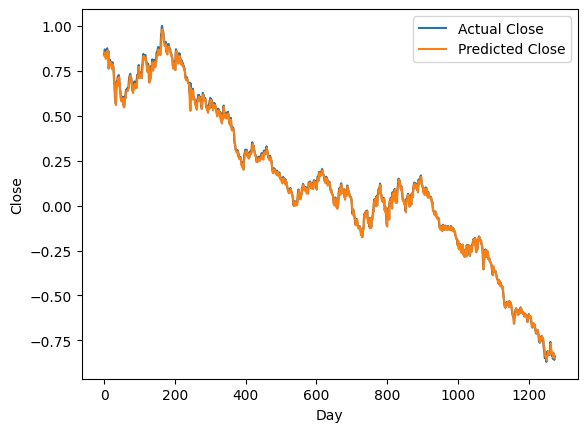

In [98]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [99]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([24714.06769682, 24650.51801354, 24686.22755915, ...,
        9059.30510072,  9002.02399528,  9032.97929176])

In [100]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

<ipython-input-100-2b76640e40df>:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([24752.44991339, 24826.20010601, 25001.1502637 , ...,
        8925.30004035,  8993.85016901,  9111.90016004])

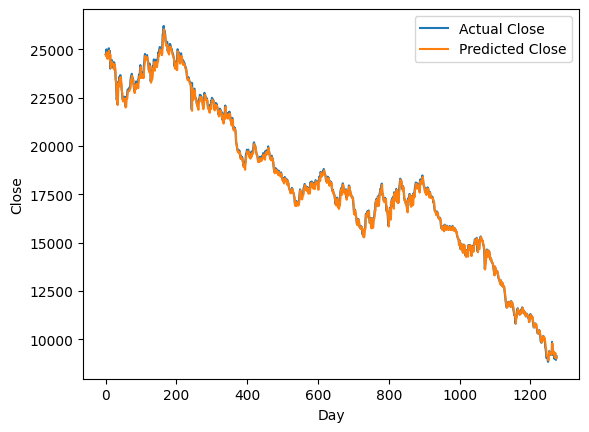

In [101]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [102]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 9118.12382371,  8839.62818266,  8868.67823071,  8327.47400564,
        8403.7305204 ,  8602.96760508,  8380.40453507,  8672.37498463,
        8656.31012508,  8444.3268397 ,  8074.92822523,  7892.121413  ,
        8644.59196005,  8305.29360915,  8516.29377303,  8896.85051152,
        9120.25087056,  9828.24140797,  9546.32563528, 10395.95553469,
       10361.87232599, 10933.44962669, 11192.6643311 , 11197.15685809,
       11275.3862698 , 11111.79939966, 11189.74102792, 11596.07462428,
       11615.67384166, 11760.18992916, 11791.25057989, 12050.99371903,
       12077.90285783, 11956.73937148, 12027.27016003, 12081.9645414 ,
       12139.58610741, 12165.68180051, 12074.79435298, 12009.21133268,
       12075.8307061 , 12103.58933285, 12054.79146248, 11953.31258589,
       11692.64399284, 11657.79114363, 11937.30428493, 11982.99365045,
       12090.65848497, 12017.61915628, 12095.4831551 , 12216.34166862,
       12139.14251058, 12080.67866506, 12146.943161  , 12190.9646024 ,
      

In [103]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

<ipython-input-103-de35d29ffb5f>:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([ 8748.75016155,  8792.19991753,  8083.80016202,  8253.79977898,
        8597.74979725,  8281.0998375 ,  8660.24981951,  8641.45018544,
        8317.8501722 ,  7801.04987278,  7610.25      ,  8745.44980106,
        8263.45022823,  8468.80007736,  8967.05026593,  9197.40012396,
        9955.19993255,  9590.15023059, 10458.40010735, 10451.45005386,
       10989.44984626, 11269.0001388 , 11251.00008802, 11303.30015545,
       11132.74992391, 11201.74974887, 11633.30016209, 11678.4999076 ,
       11797.90009652, 11829.39990812, 12080.85000434, 12125.90003591,
       11992.49993073, 12045.79975453, 12113.4499361 , 12174.65021963,
       12201.20004499, 12107.89998514, 12031.4998559 , 12098.34989967,
       12137.94978957, 12089.15025571, 11979.65003927, 11707.89984266,
       11661.85005471, 11962.10023929, 12035.79997277, 12129.49982427,
       12055.80009079, 12118.99988707, 12248.25014381, 12180.34988452,
       12106.90022876, 12169.84994732, 12224.54987365, 12352.35012323,
      

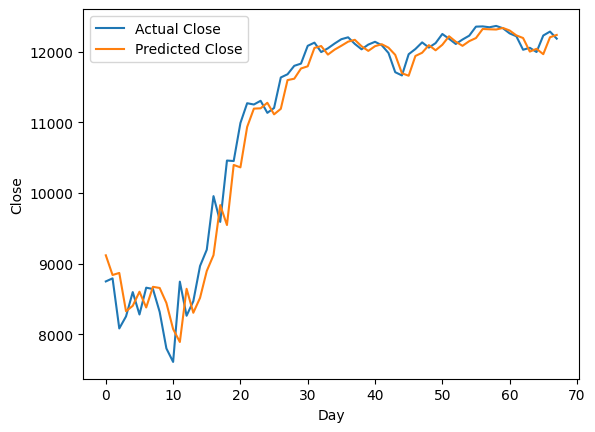

In [104]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [105]:
def evaluate_model(model, X_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()
        actuals = y_test.cpu().numpy()

    # Inverse scale both predictions and actuals
    def inverse_transform_column(col):
        dummy = np.zeros((len(col), scaler.n_features_in_))  # (n_samples, 8)
        dummy[:, 0] = col
        return scaler.inverse_transform(dummy)[:, 0]

    y_pred_unscaled = inverse_transform_column(predictions.flatten())
    y_true_unscaled = inverse_transform_column(actuals.flatten())

    # Metrics
    mae = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_true_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_unscaled, y_pred_unscaled)

    print("📈 Model Evaluation on Test Set:")
    print(f"🔹 Mean Absolute Error (MAE): {mae:.2f}")
    print(f"🔹 Mean Squared Error (MSE): {mse:.2f}")
    print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"🔹 R² Score: {r2:.4f}")

    # ✅ Make sure to return the values
    return y_true_unscaled, y_pred_unscaled

y_true, y_pred = evaluate_model(model, X_test, y_test, scaler)


📈 Model Evaluation on Test Set:
🔹 Mean Absolute Error (MAE): 196.22
🔹 Mean Squared Error (MSE): 85674.81
🔹 Root Mean Squared Error (RMSE): 292.70
🔹 R² Score: 0.9637


In [106]:
def predict_future_readable(model, last_window, scaler, n_days=7):
    """
    Predict the next `n_days` using a trained LSTM model and print readable results.

    Parameters:
    - model: Trained LSTM model
    - last_window: np.array of shape (lookback, 1), scaled input
    - scaler: The MinMaxScaler used during training
    - n_days: Number of days to predict

    Returns:
    - List of predicted close prices (original scale)
    """
    model.eval()
    predictions_scaled = []
    current_window = last_window.copy()

    print(f"\n📈 Predicting the next {n_days} Nifty 50 values:\n")

    for day in range(1, n_days + 1):
        # Model expects input shape (1, lookback, 1)
        input_tensor = torch.tensor(current_window.reshape(1, -1, 1)).float().to(device)

        with torch.no_grad():
            next_scaled = model(input_tensor).cpu().numpy()  # shape (1, 1)

        predictions_scaled.append(next_scaled[0, 0])

        # Create dummy row for inverse transform
        dummy_row = np.zeros((1, lookback + 1))
        dummy_row[0, 0] = next_scaled[0, 0]  # first col = predicted value
        unscaled = scaler.inverse_transform(dummy_row)[0, 0]

        print(f"🔹 Day {day}: Predicted Close = ₹{unscaled:.2f}")

        # Update window
        current_window = np.roll(current_window, -1)
        current_window[-1] = next_scaled

    # Inverse scale all predicted values
    all_unscaled = []
    for val in predictions_scaled:
        dummy_row = np.zeros((1, lookback + 1))
        dummy_row[0, 0] = val
        all_unscaled.append(scaler.inverse_transform(dummy_row)[0, 0])

    return all_unscaled


In [107]:
# Ensure last_window is from the last input row of X and reshaped properly
last_window = X[-1].reshape(-1, 1)

# Predict next 5 days
future_predictions = predict_future_readable(model, last_window, scaler, n_days=5)


📈 Predicting the next 5 Nifty 50 values:

🔹 Day 1: Predicted Close = ₹12234.74
🔹 Day 2: Predicted Close = ₹12196.93
🔹 Day 3: Predicted Close = ₹12170.06
🔹 Day 4: Predicted Close = ₹12143.95
🔹 Day 5: Predicted Close = ₹12116.57
